# Biometrics: _Fingerprint Recognition_

In this project different fingerprint recognition systems are implemented. These systems are evaluated in three databases provided (DB2_B, DB3_B, DB4_B).

### Minutiae Extraction and matching

The basis FPR matching is based on matching keypoints, called minutiae. They are defined as the ridge endings and bifurcations and can be easily determined by first thresholding and skeletonizing/thinning the enhanced image.  
Instead, based on the developments in Computer Vision, the use of keypoint features turns out to be very succesfull, too.    

### Importing packages

In [2]:
import cv2
import numpy as np
import argparse
from matplotlib import pyplot as plt
import fprmodules.enhancement as fe
import glob
import statistics 
from sklearn.metrics import roc_curve, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d

In [3]:
# to plot the figures inside the notebook:
%matplotlib inline

### Reading two random images, convert to gray scale and plot

In [240]:
image1_name = "fprdata/DB2_B/108_1.tif"
image2_name = "fprdata/DB2_B/108_4.tif"

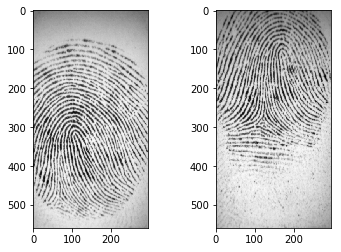

In [242]:
img_1 = cv2.imread(image1_name)
# convert to gray if color
if(len(img_1.shape)>2):
     img_1 = cv2.cvtColor(img_1,cv2.COLOR_BGR2GRAY)

img_2 = cv2.imread(image2_name)
# convert to gray if color
if(len(img_2.shape)>2):
     img_2 = cv2.cvtColor(img_2,cv2.COLOR_BGR2GRAY)
        
#plot        
plt.subplot(1,2,1)
plt.imshow(img_1, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_2, cmap='gray')
plt.show()

### Enhancement using ridge orientation and frequency estimation

Code developed by [Utkarsh Deshmukh][https://github.com/Utkarsh-Deshmukh/Fingerprint-Enhancement-Python] is re-used, which is a Python-recode of Matlab-code developed by [Peter Kovesi][https://www.peterkovesi.com/matlabfns/index.html#fingerprints], which has been slightly adapted to be more compliant with OpenCV. It uses gradient-based orientation and local frequency estimation as input to an orientation and frequency selective filtering using a Gabor filterbank. At the same time, a foreground region segmentation (mask) is determined by calculating the standard deviation in local windows and thresholding above a certain level. 

In [4]:
def imageEnhancement(img):
    # frequency and orientation selective filtering/enhancement
    img_e, mask, orient, freq = fe.image_enhance(img);
    
    # normalize the floating point values to a uint8 range
    img_enhanced = cv2.normalize(img_e, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=0)
    return img_enhanced

## Authentication/Verification Scenarios

In order to detect the matching keypoints in the authentication/verification scenario, ORB, SIFT and SURF are presented, as well as the homography transformation and are used properly for this reason. In each case, different matching methods are used. In more details, the first matching method uses as a criterion the sum of matches between two fingerpints; the more the matches, the better it is. The second matching method uses as a criterion the matching distance between the best matching keypoints; it calculates the matching distances between the best matching keypoints of two fingerprints (a proportion of the total matching keypoints is used), and keeps the median one. And finally, the third matching method calculates the matching distances between the best matching keypoints of two fingerprints (a proportion of the total matching keypoints is used again), and keeps the average value. In general, the less the distance the better it is. 
These three different matching methods are tested for both ORB and SIFT algorithms. The first one is used for SURF too. Also, as an extra scenario, homography is applied to the images, and then ORB algorithm is used again, to detect the matching keypoints between the initial images and the aligned ones and then the sum of the matches is calculated. Those images with more matches are supoosed to match better.

### Feature Detection and Description with ORB

Subsequently, ORB algorithm is impemented. It detects and describes keypoints and features and returns the matches found.
Initially, a simple example of ORB is presented, with which, the two inital custom images, image1_name and image2_name, are compared and plotted. Then, the ten best matches are drawn on them.   

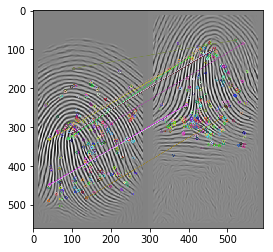

(<matplotlib.image.AxesImage at 0x286594672e8>, None)

In [243]:
MAX_FEATURES = 500

# Initiate ORB detector
orb = cv2.ORB_create(MAX_FEATURES)

#enhance and normalize images
img_e_u_1 = imageEnhancement(img_1)
img_e_u_2 = imageEnhancement(img_2)

kp1, des1 = orb.detectAndCompute(img_e_u_1,None)
kp2, des2 = orb.detectAndCompute(img_e_u_2,None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING2, crossCheck=True)

matches = bf.match(des1,des2)

# sort matches based on feature distance
# matches = sorted(matches, key=lambda x: x.distance)
matches.sort(key=lambda x: x.distance, reverse=False)

# Draw top 10 matches
imMatches = cv2.drawMatches(img_e_u_1,kp1,img_e_u_2,kp2,matches[:10], None) #, flags=2)

plt.imshow(imMatches),plt.show()

### Extend ORB

In this part, the initial implementation of the ORB algorithm has been extended so that according to the metric used, to return different matching information. In more details, it detects and describes keypoints and features, and returns either the sum of the best matches found, the average distance of the best matches, or the total distance of the best matches. The best matches, are declared as a percentage of the total matches.

In [5]:
def ORBdetector(img1,img2,case="average_distance"):
    MAX_FEATURES=4000
    # Initiate ORB detector
    orb = cv2.ORB_create(MAX_FEATURES)
    
    # find the keypoints and descriptors with ORB    
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)
    
    #For binary string based descriptors like ORB, BRIEF, BRISK etc, 
    #cv2.NORM_HAMMING should be used, which uses Hamming distance as measurement.
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1,des2)
    
    # sort matches based on feature distance
    # matches = sorted(matches, key=lambda x: x.distance)
    matches.sort(key=lambda x: x.distance, reverse=False)
    #print(len(matches))
    
    # Remove not so good matches and keep the average distance of the best matches 
    numGoodMatches = int(len(matches) * 0.25)
    matches = matches[:numGoodMatches]
    
    distance_arr=[]
    if case=='feature_sum':
        return matches
    elif case=='median_distance':           
        for m in matches:
            distance_arr.append(m.distance)
        if (len(distance_arr) != 0):        
            median_distance = statistics.median(distance_arr)
        else:
            median_distance = 0.0
        return median_distance  
    elif case=='average_distance':    
        sum=0
        for m in matches:
            sum+=m.distance     
        if (len(matches) != 0):
            average_distance = sum /len(matches)
        else:
            average_distance = 0.0
        return average_distance

### Feature Detection and Description with SIFT

Moreover, SIFT algorithm is preseted. It detects and describes keypoints and features, and returns either the sum of the best matches found, or the average distance of the best matches, or the total distance of the best matches. The best matches, are declared as a percentage of the total matches. 
Reference: https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_matcher/py_matcher.html

In [6]:
def SIFTdetector(img1,img2,case="average_distance"):
    # Initialize sift feature extractor
    sift = cv2.xfeatures2d.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    
    #Brute Force Matching
    #Use the metric Brute Force Matching that compares the descriptors des1, des2 
    # BFMatcher with default params in the case of SIFT
    # Distance measurement to be used is by default cv2.NORM_L2, crossCheck=False
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)
    #print(len(matches))
    
    
    # Apply ratio test
    filtered_matches = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            filtered_matches.append([m])
    
    distance_arr=[]
    if case=='feature_sum':
        return filtered_matches
    elif case=='median_distance':
        for m in filtered_matches:
            for n in m:
                distance_arr.append(n.distance)
        if (len(distance_arr) != 0):        
            median_distance = statistics.median(distance_arr)
        else:
            median_distance = 0.0
        return median_distance;     
    elif case=='average_distance':    
        sum=0
        for m in filtered_matches:
            for n in m:
                sum+=n.distance
        if (len(filtered_matches) != 0):
            average_distance = sum /len(filtered_matches)
        else:
            average_distance = 0.0
        return average_distance;     
    
    #Draw good matches
    #img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,filtered_matches, None, flags=2)
    #plt.imshow(img3),plt.show()

### Feature Detection and Description with SURF

Finally, SURF algorithm is presented. It detects and describes keypoints and features, and returns the best matches found (checks only number this algorithm). 

In [7]:
def SURFdetector(img1,img2, case='feature_sum'):
    
    # Initialize surf feature extractor
    surf = cv2.xfeatures2d.SURF_create()
    
    kp1, des1 = surf.detectAndCompute(img1, None)
    kp2, des2 = surf.detectAndCompute(img2, None)
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)
    
    best_matches = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            best_matches.append([m])
            
    return best_matches        

### Decision function based on the number of matching features


Subsequently, a decision function is declared. The number of matching features is taken into consideration, and four different cases are stated in order to compute the True positive, False positive, True negative, False negative matchings; the more the matches the best it is. Also, someone should notice that when a fingerprint that is compared with another fingerprint belongs to the same person should match, and in a different case should not match.

So, this function takes as argument a list of matches, a threshold, and a label with value 'true' or 'false', meaning whether two images should indeed match or not.

In [8]:
def DecisionTotalMatches(matches, threshold, label):
    if (len(matches) >= threshold and label =='true'): # true positive case
        return "TP"
    elif (len(matches) >= threshold and label =='false'): # false positive case
        return "FP"
    elif (len(matches) < threshold and label =='true'): # false negative case
        return "FN"      
    elif (len(matches) < threshold and label =='false'): #true negative case
        return "TN"  

### Decision function based on feature distances

In addition, a second decision function is declared. In this case, the feature distances are taken into consideration in order to declare whether two images match. Again, four different cases are declared for computing the True positive, True negative, False positive, False negative matchings; though the difference in this case is that the less the distanes, the best the matcing.  

This matching function takes as argument a list of matches, a threshold, and a label with value 'true' or 'false', meaning whether two images should indeed match or not.

In [9]:
def DecisionDistanceMatches(matches, threshold, label):
    if (matches <= threshold and label =='true'): # true positive case
        return "TP"
    elif (matches <= threshold and label =='false'): # false positive case
        return "FP"
    elif (matches > threshold and label =='true'): # false negative case
        return "FN"      
    elif (matches > threshold and label =='false'): #true negative case
        return "TN" 

### Function that computes ROC curve

Here, a function that calculates the False positive rate and the True positive rate (sensitivity) is developed. In more details, the True positive rate is equal to TP/(TP+FN) and the False positive rate is equal to FP/(FP+TN). The function takes as inputs, an array of threshold values according to which the ROC curve will be created later on, the matching function which will be used (that is to say, whether the matches will be calculated based on the distance of matches or their sum), the algorithm that will be used, meaning SIFT or ORB and finally the argument case_ , which declares which metric the algorithm will take into consideration; either the average distance of all the matches, the median distance of all the matches or the number of all the matches. Finally it returns the false positive rate and the true positive rate. We will call this method, custom-made ROC curve, throughout this project.    


In [178]:
def computeROC(threshold, database, matchingFucntion, algorithm, case_=''):
    sensitivity_arr=[]
    FPR_array=[ ]
    for j in range(len(threshold)):
        TP = FP = TN = FN = 0
        for item in database:
            img1 = cv2.imread(item)
            label1= item[-9:-6]
            for obj in database:
                img2 = cv2.imread(obj)
                label2= obj[-9:-6]
                if label1==label2:
                    label='true'
                else:
                    label='false'
                if algorithm=='SIFT':                    
                    matches=SIFTdetector(img1,img2,case_)
                elif algorithm=='ORB':
                    matches=ORBdetector(img1,img2,case_)                        
                #print(len(matches))
                if matchingFucntion=='totalMatches':
                    case = (DecisionTotalMatches(matches, threshold[j], label))
                elif matchingFucntion=='distance':                    
                    case = (DecisionDistanceMatches(matches, threshold[j], label))
                if (case=='FP'):
                    FP+=1
                elif (case=='FN'):
                    FN+=1
                elif (case=='TP'):
                    TP+=1
                elif (case=='TN'):
                    TN+=1                
            
            TP-=1 #Subtract number 1, as the first comparison is between the same figerprints each time.               
        
        sensitivity = TP/(TP+FN)
        sensitivity_arr.append(sensitivity)
        false_positive_rate = FP/(FP+TN)
        FPR_array.append(false_positive_rate)

    return sensitivity_arr, FPR_array

## Evaluate on the Database DB2_B

In this part, the detection and matching functions that were constructed earlier are tested on the DB2_B database. Initially, the data are loaded from the database, some processing steps are applied in order to enhance and normalize the image data, and then ROC curve is plotted. As a first step, in order to calculate the FPR and the TPR and to plot, finally, the ROC curve, the method computeROC() is used, which is the method that I created. For this reason, after a lot of experimenets and calculations, the proper thresholds had to be selected for each case, which was totally time consuming, and as a result, three cases are tested in this first plot attempt. Subsequently, this process is illustrated.     

Reading image data from DB2_B and convert to gray scale. Subsequently, enhance and normalize the images

In [244]:
dataPath="fprdata/DB2_B/*.*"
databaseInitial=(glob.glob(dataPath))

Reading image data, process and store to disk
Frequency and orientation selective filtering/enhancement and normalization
Store the processed images in DB2_B_Enhanced file. Retain the same names

In [245]:
for item in databaseInitial:
    img = cv2.imread(item)
    # convert image to gray if color
    if(len(img.shape)>2):
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_enhanced = imageEnhancement(img)   
    cv2.imwrite('fprdata/DB2_B_Enhanced/' + '%s' % (item[-9:]), img_enhanced)

Retrieve image data, and store to database array DB2_B_Enhanced. 

In [4]:
path="fprdata/DB2_B_Enhanced/*.*"
DB2_B_Enhanced=(glob.glob(path))

Retrieve an enhanced-normalized image and plot it. 
An image is plotted from the database DB2_B, after being enhanced and normalized.

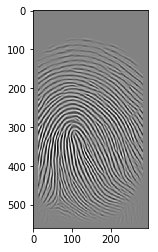

In [247]:
image3 = "fprdata/DB2_B_Enhanced/108_1.tif"

img_3 = cv2.imread(image3)
# convert to gray if color
if(len(img_3.shape)>2):
     img_3 = cv2.cvtColor(img_3,cv2.COLOR_BGR2GRAY)

plt.imshow(img_3,cmap='gray')
plt.show()

### Database DB2_B after enhancement-normalization

### Test the authentication scenario using the matching and decision methods, that were just presented above and the custom-made ROC curve.

So, firstly, three different cases of comparing fingerprints are tested and plotted in an ROC curve. First of all, the SIFT detection algorithm is used with matching method the median distance as well as the sum of matches and also the ORB algorithm which checks the sum of matches. For these cases, the True Positive and False Positive Rates are calculated. All these tests take place in the enhanced version of the DB2_B database.  

In [17]:
TRP_SIFT_median, FPR_SIFT_median = computeROC([40, 70, 90, 120, 130, 140, 150, 180, 220, 260], DB2_B_Enhanced, 'distance', 'SIFT', 'median_distance')

In [165]:
TPR_ORB_sum, FPR_ORB_sum = computeROC([410, 370, 340, 335, 330, 300, 270, 260, 240, 210], DB2_B_Enhanced, 'totalMatches', 'ORB', 'feature_sum')

In [183]:
TPR_SIFT_sum, FPR_SIFT_sum = computeROC([32, 20, 10, 8, 7, 5, 3, 2, 1, 0.2], DB2_B_Enhanced, 'totalMatches', 'SIFT', 'feature_sum')

### Plot these rates in a custom-made ROC curve

The FPR and TPR that were just calculated are plotted using the computeROC() method that I created.

Text(0.5, 1.0, 'ROC')

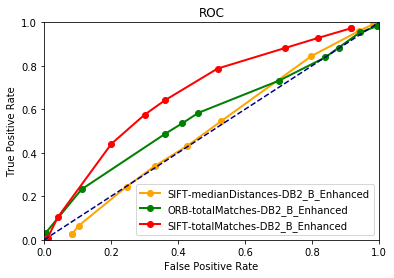

In [200]:
plt.plot(FPR_SIFT_median, TRP_SIFT_median, 'o-', color='orange', linewidth=2.0, label='SIFT-medianDistances-DB2_B_Enhanced')
plt.plot(FPR_ORB_sum, TPR_ORB_sum, 'o-', color='green', linewidth=2.0, label='ORB-totalMatches-DB2_B_Enhanced')
plt.plot(FPR_SIFT_sum, TPR_SIFT_sum, 'o-', color='red', linewidth=2.0, label='SIFT-totalMatches-DB2_B_Enhanced')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend(loc='lower right')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC")

As someone can notice from the ROC curve, comparing these three cases in the enhanced verion of the DB2_B database, taking into consideration the sum of best matches when using the SIFT algorithm proves to be the best choice, although it is not the ideal one. For this reason, trying to find a better approach, all the other scenarios/matching methods are checked too, subsequently, in order to come up to a safe conclucion. Because calculating the appropriate thresholds needed for the computeROC() method is extremely time consuming, all the other tests use the built-in function sklearn.metrics.roc_curve. So, the same process follows, using this time the built-in function sklearn.metrics.roc_curve. But first of all, for this reason, some more methods are created that will be used later on.   

Here, a method that normalizes data is constructed. All the values are mapped between 0 and 1.Using this function. 

In [14]:
#Create a method that normalizes data between 0 and 1.
def normalization(arr):
    xmax, xmin = arr.max(), arr.min()
    normalized = (arr - xmin)/(xmax - xmin)
    return normalized

Now, a method totalFeaturesArray() is declared that creates a matrix which will contain in each position, the number of matches between every pair of images in the given database. Each position will have a number which will represent the number of matches between two images. This function takes as arguments the database for which we want to calculate the matches, and the algorithm that will be used for that, meaning SIFT, RBF or SURF. 

In [15]:
def totalFeaturesArray(db, algorithm):
    arr=np.zeros((80,80))
    for i in range(len(db)):
        img1 = cv2.imread(db[i])
        for j in range(len(db)):
            img2=cv2.imread(db[j])
            arr[i,j]=len(algorithm(img1,img2,'feature_sum'))
    return arr
    

Here, a method distancesArray() is declared that creates a matrix which will contain in each position, the sum of the match distances between every pair of images in the given database. In other words, each position of the matrix will have a number which will represent the sum of the distances of all the matches between two images. This function takes as arguments the database for which we want to calculate the matches, the algorithm that will be used for that, meaning SIFT or ORB and finally the metric that want to be used; median_distance or average_distance.

In [16]:
def distancesArray(db, algorithm, case):
    arr=np.zeros((80,80)) 
    for i in range(len(db)):
        img1 = cv2.imread(db[i])
        for j in range(len(db)):
            img2=cv2.imread(db[j])
            arr[i,j] = algorithm(img1,img2,case)
    return arr

In the case of checking the total number of matches between two fingerprints, the more the matches the better it is. Also, when a fingerprint is compared with another fingerprint that belongs to the same person, then these two fingerprints should match (the label 1, is assigned to such a matching), and when it is compared with a fingerprint that does not belong to the same person, then actually they shouldn't match (the label 0, is assigned this comparison). In other words, 1 means that they should match, and 0 that they shouldn;t match. 
So, according to this logic, a matrix is constructed which contains the true binary labels.   

In [17]:
#Create a matrix containing the true labels for the total matches case. 
matching_labels=np.zeros((80,80), dtype=int)

ck=0
counter=0
for i in range(0,80):
    for j in range(0+ck,8+ck):
        matching_labels[i,j] = 1
    counter+=1
    if counter==8:
        ck+=8
        counter=0
#print(matching_labels)
#print(np.shape(matching_labels))

For the case of checking match distances instead of total matches between images, the opposite array must be constructed, since the lower the distances the better the matching! This means that the corresponding true label matrix in this case will have 0 value when two images truly match, and 1 when they shouldn't match. 

In [18]:
#Create a matrix containing the true labels for the total distances case. 
distance_labels=np.ones((80,80), dtype=int)

ck=0
counter=0
for i in range(0,80):
    for j in range(0+ck,8+ck):
        distance_labels[i,j] = 0
    counter+=1
    if counter==8:
        ck+=8
        counter=0
#print(distance_labels)
#print(np.shape(distance_labels))

### Test the authentication scenario using the matching methods, that were presented above and the built-in function sklearn.metrics.roc_curve

Later on, we create the matrices ORb_totalFeatures_DB2_B and SIFT_totalFeatures_DB2_B, that contain the number of matches between all images, as they are acquired by the ORB and SIFT algorithm respectively, for the database DB2_B_Enhanced (enhanced/normalized version of the DB2_B database), as well as the SIFT_FeatureDistances_DB2_B and the ORB_MedianDistances_DB2_B that contain the median distances for every pair of image matching, using the SIFT and the ORB algorithms respectively. Finally, we create the ORB_AverageDistances_DB2_B and SIFT_AverageDistances_DB2_B, again for the database DB2_B_Enhanced, that contain the average distances for every image matching.

In [68]:
ORb_totalFeatures_DB2_B = totalFeaturesArray(DB2_B_Enhanced, ORBdetector)
SIFT_totalFeatures_DB2_B = totalFeaturesArray(DB2_B_Enhanced, SIFTdetector)
SIFT_FeatureDistances_DB2_B = distancesArray(DB2_B_Enhanced, SIFTdetector, 'median_distance')
ORB_MedianDistances_DB2_B = distancesArray(DB2_B_Enhanced, ORBdetector, 'median_distance')
ORB_AverageDistances_DB2_B = distancesArray(DB2_B_Enhanced, ORBdetector, 'average_distance')
SIFT_AverageDistances_DB2_B = distancesArray(DB2_B_Enhanced, SIFTdetector, 'average_distance')

Normalize the matrices below, so that contain values between 0 and 1

In [152]:
ORb_totalFeatures_DB2_B_normalized=normalization(ORb_totalFeatures_DB2_B)
SIFT_totalFeatures_DB2_B_normalized=normalization(SIFT_totalFeatures_DB2_B)
SIFT_FeatureDistances_DB2_B_normalized=normalization(SIFT_FeatureDistances_DB2_B)
ORB_MedianDistances_DB2_B_normalized=normalization(ORB_MedianDistances_DB2_B)
ORB_AverageDistances_DB2_B_normalized=normalization(ORB_AverageDistances_DB2_B)
SIFT_AverageDistances_DB2_B_normalized=normalization(SIFT_AverageDistances_DB2_B)

Now, using the built-in sklearn.metrics.roc_curve, corresponding plots are provided. 
Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

* The overall performance (over all threshold settings) can be expressed through:
    * the Area Under the Curve (AUC)
    ![AUC](Images/AUC.png)
    * the Equal Error Rate (EER). A lower EER value indicates better performance. ![EER](Images/EER.png)

So, for a safe conclusion, the ROC curve is plotted and the Equal Error Rate (EER) on ROC curve is computed, too.
Reference: https://gist.github.com/aqzlpm11/9e33a20c5e8347537bec532ae7319ba8 


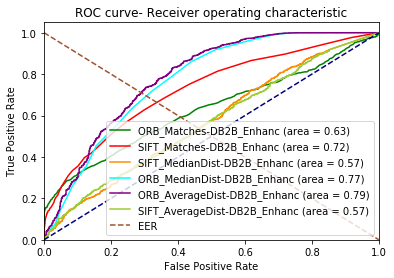

No. of Matches using ORB: EER = 0.40839120370370363
No. of Matches using SIFT: EER = 0.3367290748899052
Median Distances using SIFT: EER = 0.46156250000000004
Median Distances using ORB: EER = 0.3055718638525565
Average Distances using ORB: EER = 0.2906249999989071
Average Distances using SIFT: EER = 0.4624999999987316


In [190]:
from sklearn.metrics import roc_curve, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d

fpr1, tpr1, thresholds1 = roc_curve(matching_labels.flatten(), ORb_totalFeatures_DB2_B_normalized.flatten())
fpr2, tpr2, thresholds2 = roc_curve(matching_labels.flatten(), SIFT_totalFeatures_DB2_B_normalized.flatten())
fpr3, tpr3, thresholds3 = roc_curve(distance_labels.flatten(), SIFT_FeatureDistances_DB2_B_normalized.flatten())
fpr4, tpr4, thresholds4 = roc_curve(distance_labels.flatten(), ORB_MedianDistances_DB2_B_normalized.flatten())
fpr5, tpr5, thresholds5 = roc_curve(distance_labels.flatten(), ORB_AverageDistances_DB2_B_normalized.flatten())
fpr6, tpr6, thresholds6 = roc_curve(distance_labels.flatten(), SIFT_AverageDistances_DB2_B_normalized.flatten())

roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
roc_auc5 = auc(fpr5, tpr5)
roc_auc6 = auc(fpr6, tpr6)

plt.figure()
plt.plot(fpr1, tpr1, color='green', label='ORB_Matches-DB2B_Enhanc (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='red', label='SIFT_Matches-DB2B_Enhanc (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='darkorange', label='SIFT_MedianDist-DB2B_Enhanc (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, color='cyan', label='ORB_MedianDist-DB2B_Enhanc (area = %0.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, color='purple', label='ORB_AverageDist-DB2B_Enhanc (area = %0.2f)' % roc_auc5)
plt.plot(fpr6, tpr6, color='yellowgreen', label='SIFT_AverageDist-DB2B_Enhanc (area = %0.2f)' % roc_auc6)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.plot([0, 1], [1, 0], color='sienna', linestyle='--', label='EER')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve- Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#Calculate the EER for each case
eer1 = brentq(lambda x : 1. - x - interp1d(fpr1, tpr1)(x), 0., 1.)
eer2 = brentq(lambda x : 1. - x - interp1d(fpr2, tpr2)(x), 0., 1.)
eer3 = brentq(lambda x : 1. - x - interp1d(fpr3, tpr3)(x), 0., 1.)
eer4 = brentq(lambda x : 1. - x - interp1d(fpr4, tpr4)(x), 0., 1.)
eer5 = brentq(lambda x : 1. - x - interp1d(fpr5, tpr5)(x), 0., 1.)
eer6 = brentq(lambda x : 1. - x - interp1d(fpr6, tpr6)(x), 0., 1.)
print('No. of Matches using ORB: EER =', eer1)
print('No. of Matches using SIFT: EER =', eer2)
print('Median Distances using SIFT: EER =', eer3)
print('Median Distances using ORB: EER =', eer4)
print('Average Distances using ORB: EER =', eer5)
print('Average Distances using SIFT: EER =', eer6)

First of all, when comparing the plot that was constructed when using the computeROC() method, with the plot that we get when using the built-in sklearn.metrics.roc_curve, we can notice that they are almost the same for the three different cases presented in the first plot (sum matches with ORB, sum matches with SIFT, mean distance with SIFT). The small differencies that may exist, are due to the different thresholds used in each case.    
Also, comparing all the six different cases that are presented in the last plot, someone can notice that the use of ORB detector and median distance as the decision criterion has the best perfomance, with the smallest EER and a bigger area under the curve (AUC). Also, the combination of ORB algorith with average distance has similar perfomance.   

### Database DB2_B without enhancement-normalization

Now, the same process is repeated for the images contained in the database DB2_B, without having been enhanced or normalized. Just in their initial state. 

In [195]:
ORB_FeatureSum_DB2_B_Initial = totalFeaturesArray(databaseInitial, ORBdetector)
SIFT_FeatureSum_DB2_B_Initial = totalFeaturesArray(databaseInitial, SIFTdetector)
SIFT_MedianDistances_DB2_B_Initial = distancesArray(databaseInitial, SIFTdetector, 'median_distance')
ORB_MedianDistances_DB2_B_Initial = distancesArray(databaseInitial, ORBdetector, 'median_distance')
ORB_AverDistances_DB2_B_Initial = distancesArray(databaseInitial, ORBdetector, 'average_distance')
SIFT_AverDistances_DB2_B_Initial = distancesArray(databaseInitial, SIFTdetector, 'average_distance')

Rescale values between 0 and 1

In [202]:
ORb_Features_Initial_DB2_B_normalized=normalization(ORB_FeatureSum_DB2_B_Initial)
SIFT_Features_Initial_DB2_B_normalized=normalization(SIFT_FeatureSum_DB2_B_Initial)
SIFT_MedDist_Initial_DB2_B_normalized=normalization(SIFT_MedianDistances_DB2_B_Initial)
ORB_MedDist_Initial_DB2_B_normalized=normalization(ORB_MedianDistances_DB2_B_Initial)
ORB_AverDist_Initial_DB2_B_normalized=normalization(ORB_AverDistances_DB2_B_Initial)
SIFT_AverDist_Initial_DB2_B_normalized=normalization(SIFT_AverDistances_DB2_B_Initial)

Subsequently, the ROC curve is created for these datasets

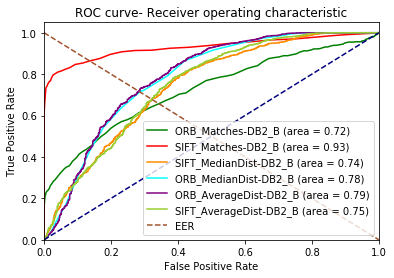

No. of Matches using ORB: EER = 0.3429961622807017
No. of Matches using SIFT: EER = 0.13627752590673572
Median Distances using SIFT: EER = 0.32221283783783783
Median Distances using ORB: EER = 0.2859375
Average Distances using ORB: EER = 0.28281249999961666
Average Distances using SIFT: EER = 0.3218750000006152


In [205]:
fpr1, tpr1, thresholds1 = roc_curve(matching_labels.flatten(), ORb_Features_Initial_DB2_B_normalized.flatten())
fpr2, tpr2, thresholds2 = roc_curve(matching_labels.flatten(), SIFT_Features_Initial_DB2_B_normalized.flatten())
fpr3, tpr3, thresholds3 = roc_curve(distance_labels.flatten(), SIFT_MedDist_Initial_DB2_B_normalized.flatten())
fpr4, tpr4, thresholds4 = roc_curve(distance_labels.flatten(), ORB_MedDist_Initial_DB2_B_normalized.flatten())
fpr5, tpr5, thresholds5 = roc_curve(distance_labels.flatten(), ORB_AverDist_Initial_DB2_B_normalized.flatten())
fpr6, tpr6, thresholds6 = roc_curve(distance_labels.flatten(), SIFT_AverDist_Initial_DB2_B_normalized.flatten())

roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
roc_auc5 = auc(fpr5, tpr5)
roc_auc6 = auc(fpr6, tpr6)

plt.figure()
plt.plot(fpr1, tpr1, color='green', label='ORB_Matches-DB2_B (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='red', label='SIFT_Matches-DB2_B (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='darkorange', label='SIFT_MedianDist-DB2_B (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, color='cyan', label='ORB_MedianDist-DB2_B (area = %0.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, color='purple', label='ORB_AverageDist-DB2_B (area = %0.2f)' % roc_auc5)
plt.plot(fpr6, tpr6, color='yellowgreen', label='SIFT_AverageDist-DB2_B (area = %0.2f)' % roc_auc6)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.plot([0, 1], [1, 0], color='sienna', linestyle='--', label='EER')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve- Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#Calculate the EER for each case
eer1 = brentq(lambda x : 1. - x - interp1d(fpr1, tpr1)(x), 0., 1.)
eer2 = brentq(lambda x : 1. - x - interp1d(fpr2, tpr2)(x), 0., 1.)
eer3 = brentq(lambda x : 1. - x - interp1d(fpr3, tpr3)(x), 0., 1.)
eer4 = brentq(lambda x : 1. - x - interp1d(fpr4, tpr4)(x), 0., 1.)
eer5 = brentq(lambda x : 1. - x - interp1d(fpr5, tpr5)(x), 0., 1.)
eer6 = brentq(lambda x : 1. - x - interp1d(fpr6, tpr6)(x), 0., 1.)
print('No. of Matches using ORB: EER =', eer1)
print('No. of Matches using SIFT: EER =', eer2)
print('Median Distances using SIFT: EER =', eer3)
print('Median Distances using ORB: EER =', eer4)
print('Average Distances using ORB: EER =', eer5)
print('Average Distances using SIFT: EER =', eer6)

In this case, the results have been significantly improved for all the cases, but one scenario outperforms all the others. This scenario is when using the SIFT algorithm to detect the matching keypoints and then compare the sum of best matches for all the image comparisons in order to decide when two images should match. The perfomance in this case has EER equal to 0.13627752590673572 and area under the roc curve equal to 93%, which could prove to be a good scenario.    

### Apply the SURF algorithm, for both the initial version of DB2_B as well as for DB2_B_Enhanced

In [286]:
SURF_sumFeatures_DB2_B = totalFeaturesArray(DB2_B_Enhanced, SURFdetector)
SURF_sumFeatures_DB2_B_initialDb = totalFeaturesArray(databaseInitial, SURFdetector)

Rescale values between 0 and 1

In [290]:
SURF_Features_DB2B_enhanced_normalized=normalization(SURF_sumFeatures_DB2_B)
SURF_Features_DB2B_Init_normalized=normalization(SURF_sumFeatures_DB2_B_initialDb)

Plot the ROC curve

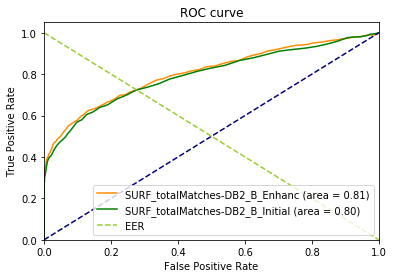

No. of Matches with SURF- Enhanced DB2_B: EER = 0.27648437499968664
No. of Matches with SURF- Initial DB2_B: EER = 0.27626369521916855


In [291]:
fpr1, tpr1, thresholds1 = roc_curve(matching_labels.flatten(), SURF_Features_DB2B_enhanced_normalized.flatten())
fpr2, tpr2, thresholds2 = roc_curve(matching_labels.flatten(), SURF_Features_DB2B_Init_normalized.flatten())

roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)

plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', label='SURF_totalMatches-DB2_B_Enhanc (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='green', label='SURF_totalMatches-DB2_B_Initial (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.plot([0, 1], [1, 0], color='yellowgreen', linestyle='--', label='EER')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

#Calculate the EER for each case
eer1 = brentq(lambda x : 1. - x - interp1d(fpr1, tpr1)(x), 0., 1.)
eer2 = brentq(lambda x : 1. - x - interp1d(fpr2, tpr2)(x), 0., 1.)
print('No. of Matches with SURF- Enhanced DB2_B: EER =', eer1)
print('No. of Matches with SURF- Initial DB2_B: EER =', eer2)

In this authentication scenario, someone can notice that in both verisons of databases, the perfomance is almost the same (almost the same AUC and EER), noting relatively good results, but still the same scenario using the SIFT allgorithm in the initial database has noted the best perfomance till now. So, trying to find even better results, subsequently, an authentication scenario will be tested using homography this time.      

### Apply homography
Reference: https://www.learnopencv.com/homography-examples-using-opencv-python-c/

Now, homography is applied to the images, and then ORB algorithm will be used to detect the matching keypoints between the initial images and the aligned ones. Finally, the sum of the matches is calculated and is used as a matching criterion. Those images with more matches are supoosed to match better.
For this reason, the method ORBwithHomography() is created. It applies keypoint matching, after having applied first Homography; a transformation for image alignment. This methodology is used subsequently, for both the DB2_B database and the enhanced/normalized version of it and we compare the results in the same plot.  

In [26]:
def ORBwithHomography(db):
    
    MAX_FEATURES = 4000
    
    arr=np.zeros((80,80)) 
    # Initiate ORB detector
    orb = cv2.ORB_create(MAX_FEATURES)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    for i in range(len(db)):        
        img1 = cv2.imread(db[i])
        kp1, des1 = orb.detectAndCompute(img1,None)        
        for j in range(len(db)):            
            img2 = cv2.imread(db[j])    
            kp2, des2 = orb.detectAndCompute(img2,None)
    
            matches = bf.match(des1,des2)
            matches.sort(key=lambda x: x.distance, reverse=False)
    
            # Remove not so good matches and keep the average distance of the best matches 
            numGoodMatches = int(len(matches) * 0.25)
            matches = matches[:numGoodMatches]
    
            dst_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
            src_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
    
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
            # Use homography
            height, width = img1.shape[:2]
            imReg = cv2.warpPerspective(img2, M, (width, height))
    
            #Detect the new features in the aligned image img2
            kp2, des2 = orb.detectAndCompute(imReg,None)
    
            #After having applied homography find again the new matches
            new_matches = bf.match(des1,des2)
            new_matches.sort(key=lambda x: x.distance, reverse=False)
            numGoodMatches = int(len(new_matches) * 0.25)
            new_matches = new_matches[:numGoodMatches]
            
            arr[i,j] = len(new_matches)
    
    return arr         

    # Draw top 10 matches
    #imMatches = cv2.drawMatches(img1,kp1,imReg,kp2,matches[:10], None) #, flags=2)
    #plt.imshow(matches),plt.show()  
            
            

Now, a matrix is created that contains at each position, the number of the keypoint matchings for each pair of images for both the DB2_B and DB2_B_Enhanced, after having applied homography transformation to these images.

In [231]:
totalMatches_ORB_AfterHomography = ORBwithHomography(DB2_B_Enhanced)
Matches_ORB_AfterHomography_initialDb = ORBwithHomography(databaseInitial)

Rescale values between 0 and 1

In [232]:
ORB_matches_Homogr_DB2_B_Enh_normal=normalization(totalMatches_ORB_AfterHomography)
ORB_matches_Homogr_DB2_B_Init_normal=normalization(Matches_ORB_AfterHomography_initialDb)

Plot the ROC curve

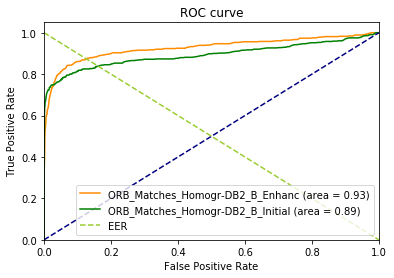

No. of Matches with ORB after Homography- Enhanced DB2_B: EER = 0.12611607142857145
No. of Matches with ORB after Homography- Initial DB2_B: EER = 0.16158088235294116


In [238]:
fpr1, tpr1, thresholds1 = roc_curve(matching_labels.flatten(), ORB_matches_Homogr_DB2_B_Enh_normal.flatten())
fpr2, tpr2, thresholds2 = roc_curve(matching_labels.flatten(), ORB_matches_Homogr_DB2_B_Init_normal.flatten())

roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)

plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', label='ORB_Matches_Homogr-DB2_B_Enhanc (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='green', label='ORB_Matches_Homogr-DB2_B_Initial (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.plot([0, 1], [1, 0], color='yellowgreen', linestyle='--', label='EER')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

#Calculate the EER for each case
eer1 = brentq(lambda x : 1. - x - interp1d(fpr1, tpr1)(x), 0., 1.)
eer2 = brentq(lambda x : 1. - x - interp1d(fpr2, tpr2)(x), 0., 1.)
print('No. of Matches with ORB after Homography- Enhanced DB2_B: EER =', eer1)
print('No. of Matches with ORB after Homography- Initial DB2_B: EER =', eer2)

In this scenario, the results are very good for both databases, a bit better though for the enhanced/normalized one. Comparing, also, all the scenarios tested for these two databases, one can say that the appliance of Homography and the use later of ORB detecting algorithm and the comparison of sum matches as a decision criterion, seems to be the best option, with AUC= 93% and EER= 0.12611607142857145, for the initial database and AUC=89%, EER=0.16158088235294116 for the enhanced/normalized one. Also, it is worth mentioning that similar results are acquired when using the SIFT algorithm and the comparison of total matches, without applying homography in the inital database though, with EER=0.13627752590673572 and AUC=0.93. Also, in all scenarios, when using either SIFT or ORB, when saying total matches, the best total matches are mentioned in all cases and in all scenarios!    

Subsequently, all these scenarios are tested for more databases. 

## Evaluate on the Database DB3_B

Read initially the data, enhance/normalize them and store to disk. 

In [251]:
dataPath3="fprdata/DB3_B/*.*"
databaseInitial3=(glob.glob(dataPath3))

In [252]:
for item in databaseInitial3:
    img = cv2.imread(item)
    # convert image to gray if color
    if(len(img.shape)>2):
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_enhanced = imageEnhancement(img)   
    cv2.imwrite('fprdata/DB3_B_Enhanced/' + '%s' % (item[-9:]), img_enhanced)

In [253]:
path3="fprdata/DB3_B_Enhanced/*.*"
DB3_B_Enhanced=(glob.glob(path3))

Now, all the scenarios will be tested for this database for both the initial Database DB3_B and the DB3_B_Enhanced

### Database DB3_B after enhancement-normalization

In [254]:
ORb_totalFeatures_DB3_B = totalFeaturesArray(DB3_B_Enhanced, ORBdetector)
SIFT_totalFeatures_DB3_B = totalFeaturesArray(DB3_B_Enhanced, SIFTdetector)
SIFT_FeatureDistances_DB3_B = distancesArray(DB3_B_Enhanced, SIFTdetector, 'median_distance')
ORB_MedianDistances_DB3_B = distancesArray(DB3_B_Enhanced, ORBdetector, 'median_distance')
ORB_AverageDistances_DB3_B = distancesArray(DB3_B_Enhanced, ORBdetector, 'average_distance')
SIFT_AverageDistances_DB3_B = distancesArray(DB3_B_Enhanced, SIFTdetector, 'average_distance')
totalMatches_ORB_AfterHomography = ORBwithHomography(DB3_B_Enhanced)
SURF_sumFeatures_DB3_B = totalFeaturesArray(DB3_B_Enhanced, SURFdetector)

Rescale values between 0 and 1

In [261]:
ORb_totalFeatures_DB3_B_normalized=normalization(ORb_totalFeatures_DB3_B)
SIFT_totalFeatures_DB3_B_normalized=normalization(SIFT_totalFeatures_DB3_B)
SIFT_FeatureDistances_DB3_B_normalized=normalization(SIFT_FeatureDistances_DB3_B)
ORB_MedianDistances_DB3_B_normalized=normalization(ORB_MedianDistances_DB3_B)
ORB_AverageDistances_DB3_B_normalized=normalization(ORB_AverageDistances_DB3_B)
SIFT_AverageDistances_DB3_B_normalized=normalization(SIFT_AverageDistances_DB3_B)
ORB_matches_Homogr_DB3_B_Enh_normal=normalization(totalMatches_ORB_AfterHomography)
SURF_totalMatches_DB3_B_Enhanced_normal=normalization(SURF_sumFeatures_DB3_B)

Plot the ROC curve

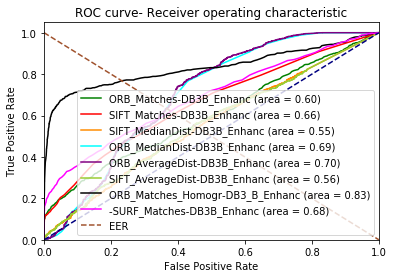

No. of Matches using ORB: EER = 0.4468750000000063
No. of Matches using SIFT: EER = 0.39048551756885097
Median Distances using SIFT: EER = 0.45781250000140933
Median Distances using ORB: EER = 0.3648863636363636
Average Distances using ORB: EER = 0.3658653846157066
Average Distances using SIFT: EER = 0.4486111111111886
No. of Matches with ORB after Homography- Enhanced DB3_B: EER = 0.2322140957446808
No. of Matches using SURF: EER = 0.37896086626139824


In [295]:
fpr1, tpr1, thresholds1 = roc_curve(matching_labels.flatten(), ORb_totalFeatures_DB3_B_normalized.flatten())
fpr2, tpr2, thresholds2 = roc_curve(matching_labels.flatten(), SIFT_totalFeatures_DB3_B_normalized.flatten())
fpr3, tpr3, thresholds3 = roc_curve(distance_labels.flatten(), SIFT_FeatureDistances_DB3_B_normalized.flatten())
fpr4, tpr4, thresholds4 = roc_curve(distance_labels.flatten(), ORB_MedianDistances_DB3_B_normalized.flatten())
fpr5, tpr5, thresholds5 = roc_curve(distance_labels.flatten(), ORB_AverageDistances_DB3_B_normalized.flatten())
fpr6, tpr6, thresholds6 = roc_curve(distance_labels.flatten(), SIFT_AverageDistances_DB3_B_normalized.flatten())
fpr7, tpr7, thresholds7 = roc_curve(matching_labels.flatten(), ORB_matches_Homogr_DB3_B_Enh_normal.flatten())
fpr8, tpr8, thresholds8 = roc_curve(matching_labels.flatten(), SURF_totalMatches_DB3_B_Enhanced_normal.flatten())

roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
roc_auc5 = auc(fpr5, tpr5)
roc_auc6 = auc(fpr6, tpr6)
roc_auc7 = auc(fpr7, tpr7)
roc_auc8 = auc(fpr8, tpr8)


plt.figure()
plt.plot(fpr1, tpr1, color='green', label='ORB_Matches-DB3B_Enhanc (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='red', label='SIFT_Matches-DB3B_Enhanc (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='darkorange', label='SIFT_MedianDist-DB3B_Enhanc (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, color='cyan', label='ORB_MedianDist-DB3B_Enhanc (area = %0.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, color='purple', label='ORB_AverageDist-DB3B_Enhanc (area = %0.2f)' % roc_auc5)
plt.plot(fpr6, tpr6, color='yellowgreen', label='SIFT_AverageDist-DB3B_Enhanc (area = %0.2f)' % roc_auc6)
plt.plot(fpr7, tpr7, color='black', label='ORB_Matches_Homogr-DB3_B_Enhanc (area = %0.2f)' % roc_auc7)
plt.plot(fpr8, tpr8, color='magenta', label='-SURF_Matches-DB3B_Enhanc (area = %0.2f)' % roc_auc8)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.plot([0, 1], [1, 0], color='sienna', linestyle='--', label='EER')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve- Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#Calculate the EER for each case
eer1 = brentq(lambda x : 1. - x - interp1d(fpr1, tpr1)(x), 0., 1.)
eer2 = brentq(lambda x : 1. - x - interp1d(fpr2, tpr2)(x), 0., 1.)
eer3 = brentq(lambda x : 1. - x - interp1d(fpr3, tpr3)(x), 0., 1.)
eer4 = brentq(lambda x : 1. - x - interp1d(fpr4, tpr4)(x), 0., 1.)
eer5 = brentq(lambda x : 1. - x - interp1d(fpr5, tpr5)(x), 0., 1.)
eer6 = brentq(lambda x : 1. - x - interp1d(fpr6, tpr6)(x), 0., 1.)
eer7 = brentq(lambda x : 1. - x - interp1d(fpr7, tpr7)(x), 0., 1.)
eer8 = brentq(lambda x : 1. - x - interp1d(fpr8, tpr8)(x), 0., 1.)
print('No. of Matches using ORB: EER =', eer1)
print('No. of Matches using SIFT: EER =', eer2)
print('Median Distances using SIFT: EER =', eer3)
print('Median Distances using ORB: EER =', eer4)
print('Average Distances using ORB: EER =', eer5)
print('Average Distances using SIFT: EER =', eer6)
print('No. of Matches with ORB after Homography- Enhanced DB3_B: EER =', eer7)
print('No. of Matches using SURF: EER =', eer8)

### Initial database DB3_B without enhancement-normalization

Now, the same process is repeated for the images contained in the database DB3_B, without having been enhanced or normalized. Just in their initial state.

In [264]:
ORB_FeatureSum_DB3_B_Initial = totalFeaturesArray(databaseInitial3, ORBdetector)
SIFT_FeatureSum_DB3_B_Initial = totalFeaturesArray(databaseInitial3, SIFTdetector)
SIFT_MedianDistances_DB3_B_Initial = distancesArray(databaseInitial3, SIFTdetector, 'median_distance')
ORB_MedianDistances_DB3_B_Initial = distancesArray(databaseInitial3, ORBdetector, 'median_distance')
ORB_AverDistances_DB3_B_Initial = distancesArray(databaseInitial3, ORBdetector, 'average_distance')
SIFT_AverDistances_DB3_B_Initial = distancesArray(databaseInitial3, SIFTdetector, 'average_distance')
Matches_ORB_AfterHomography_initialDb3 = ORBwithHomography(databaseInitial3)
SURF_FeatureSum_DB3_B_Initial = totalFeaturesArray(databaseInitial3, SURFdetector)

Rescale values between 0 and 1

In [272]:
ORb_Features_Initial_DB3_B_normalized=normalization(ORB_FeatureSum_DB3_B_Initial)
SIFT_Features_Initial_DB3_B_normalized=normalization(SIFT_FeatureSum_DB3_B_Initial)
SIFT_MedDist_Initial_DB3_B_normalized=normalization(SIFT_MedianDistances_DB3_B_Initial)
ORB_MedDist_Initial_DB3_B_normalized=normalization(ORB_MedianDistances_DB3_B_Initial)
ORB_AverDist_Initial_DB3_B_normalized=normalization(ORB_AverDistances_DB3_B_Initial)
SIFT_AverDist_Initial_DB3_B_normalized=normalization(SIFT_AverDistances_DB3_B_Initial)
ORB_matches_Homogr_DB3_B_Init_normal=normalization(Matches_ORB_AfterHomography_initialDb3)
SURF_Features_Initial_DB3_B_normalized=normalization(SURF_FeatureSum_DB3_B_Initial)

Plot the ROC curve

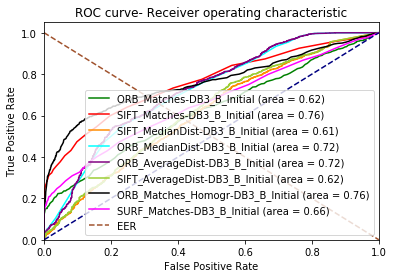

No. of Matches using ORB: EER = 0.41404532967032964
No. of Matches using SIFT: EER = 0.3156163674033149
Median Distances using SIFT: EER = 0.42986111111111114
Median Distances using ORB: EER = 0.3491583635265701
Average Distances using ORB: EER = 0.34374999999999994
Average Distances using SIFT: EER = 0.4097222222221673
No. of Matches with ORB after Homography- Initial_DB3_B: EER = 0.3031875
No. of Matches using SURF: EER = 0.39466669891640865


In [298]:
fpr1, tpr1, thresholds1 = roc_curve(matching_labels.flatten(), ORb_Features_Initial_DB3_B_normalized.flatten())
fpr2, tpr2, thresholds2 = roc_curve(matching_labels.flatten(), SIFT_Features_Initial_DB3_B_normalized.flatten())
fpr3, tpr3, thresholds3 = roc_curve(distance_labels.flatten(), SIFT_MedDist_Initial_DB3_B_normalized.flatten())
fpr4, tpr4, thresholds4 = roc_curve(distance_labels.flatten(), ORB_MedDist_Initial_DB3_B_normalized.flatten())
fpr5, tpr5, thresholds5 = roc_curve(distance_labels.flatten(), ORB_AverDist_Initial_DB3_B_normalized.flatten())
fpr6, tpr6, thresholds6 = roc_curve(distance_labels.flatten(), SIFT_AverDist_Initial_DB3_B_normalized.flatten())
fpr7, tpr7, thresholds7 = roc_curve(matching_labels.flatten(), ORB_matches_Homogr_DB3_B_Init_normal.flatten())
fpr8, tpr8, thresholds8 = roc_curve(matching_labels.flatten(), SURF_Features_Initial_DB3_B_normalized.flatten())

roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
roc_auc5 = auc(fpr5, tpr5)
roc_auc6 = auc(fpr6, tpr6)
roc_auc7 = auc(fpr7, tpr7)
roc_auc8 = auc(fpr8, tpr8)

plt.figure()
plt.plot(fpr1, tpr1, color='green', label='ORB_Matches-DB3_B_Initial (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='red', label='SIFT_Matches-DB3_B_Initial (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='darkorange', label='SIFT_MedianDist-DB3_B_Initial (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, color='cyan', label='ORB_MedianDist-DB3_B_Initial (area = %0.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, color='purple', label='ORB_AverageDist-DB3_B_Initial (area = %0.2f)' % roc_auc5)
plt.plot(fpr6, tpr6, color='yellowgreen', label='SIFT_AverageDist-DB3_B_Initial (area = %0.2f)' % roc_auc6)
plt.plot(fpr7, tpr7, color='black', label='ORB_Matches_Homogr-DB3_B_Initial (area = %0.2f)' % roc_auc7)
plt.plot(fpr8, tpr8, color='magenta', label='SURF_Matches-DB3_B_Initial (area = %0.2f)' % roc_auc8)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.plot([0, 1], [1, 0], color='sienna', linestyle='--', label='EER')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve- Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#Calculate the EER for each case
eer1 = brentq(lambda x : 1. - x - interp1d(fpr1, tpr1)(x), 0., 1.)
eer2 = brentq(lambda x : 1. - x - interp1d(fpr2, tpr2)(x), 0., 1.)
eer3 = brentq(lambda x : 1. - x - interp1d(fpr3, tpr3)(x), 0., 1.)
eer4 = brentq(lambda x : 1. - x - interp1d(fpr4, tpr4)(x), 0., 1.)
eer5 = brentq(lambda x : 1. - x - interp1d(fpr5, tpr5)(x), 0., 1.)
eer6 = brentq(lambda x : 1. - x - interp1d(fpr6, tpr6)(x), 0., 1.)
eer7 = brentq(lambda x : 1. - x - interp1d(fpr7, tpr7)(x), 0., 1.)
eer8 = brentq(lambda x : 1. - x - interp1d(fpr8, tpr8)(x), 0., 1.)
print('No. of Matches using ORB: EER =', eer1)
print('No. of Matches using SIFT: EER =', eer2)
print('Median Distances using SIFT: EER =', eer3)
print('Median Distances using ORB: EER =', eer4)
print('Average Distances using ORB: EER =', eer5)
print('Average Distances using SIFT: EER =', eer6)
print('No. of Matches with ORB after Homography- Initial_DB3_B: EER =', eer7)
print('No. of Matches using SURF: EER =', eer8)

In this case, someone could notice that the perfomance of all the authentication scenarios has been significantly decreased for both versions of databases, comparing it with the perfomance of the authentication scenarios stated in the DB2_B. However, again the best scenario proves to be the appliance of Homography and the use later of ORB detecting algorithm and the comparison of the number of matches as a decision criterion, with AUC= 83% and EER= 0.2322140957446808 for the case of the enhanced/normalized database and AUC=76% and EER=0.3031875 for the case of the normal varsion of the database.       

Comparing, also, the two databases and the perfomance stated in each of them, probably the fact that the perfomance drops in the DB3_B database could be explained due the fact that the initial appearance of the images is a bit dark, and probably it is not very helpful when detecting keypoints. That's why also, probably, the perfomance is improved when the images are enhanced/normalized, while in the database DB2_B, the opposite is happening; that is to say the authentication system works better for the inital database instead of the enhanced/normalized one. 

As a conclusion, it is worth mentioning though, that finding matching keypoints after applying Homography transformation to the images is proved to be the best option.  

## Evaluate on the Database DB4_B

Read initially the data, enhance/normalize them and store to disk.

In [10]:
dataPath4="fprdata/DB4_B/*.*"
databaseInitial4=(glob.glob(dataPath4))

In [11]:
for item in databaseInitial4:
    img = cv2.imread(item)
    # convert image to gray if color
    if(len(img.shape)>2):
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_enhanced = imageEnhancement(img)   
    cv2.imwrite('fprdata/DB4_B_Enhanced/' + '%s' % (item[-9:]), img_enhanced)

In [12]:
path4="fprdata/DB4_B_Enhanced/*.*"
DB4_B_Enhanced=(glob.glob(path4))

Now, all the scenarios will be tested again for this database for both the initial Database DB3_B and the DB3_B_Enhanced

### Database DB4_B after enhancement-normalization

In [19]:
ORb_totalFeatures_DB4_B = totalFeaturesArray(DB4_B_Enhanced, ORBdetector)
SIFT_totalFeatures_DB4_B = totalFeaturesArray(DB4_B_Enhanced, SIFTdetector)
SIFT_FeatureDistances_DB4_B = distancesArray(DB4_B_Enhanced, SIFTdetector, 'median_distance')
ORB_MedianDistances_DB4_B = distancesArray(DB4_B_Enhanced, ORBdetector, 'median_distance')
ORB_AverageDistances_DB4_B = distancesArray(DB4_B_Enhanced, ORBdetector, 'average_distance')
SIFT_AverageDistances_DB4_B = distancesArray(DB4_B_Enhanced, SIFTdetector, 'average_distance')
totalMatches_ORB_AfterHomography = ORBwithHomography(DB4_B_Enhanced)
SURF_sumFeatures_DB4_B = totalFeaturesArray(DB4_B_Enhanced, SURFdetector)

Rescale values between 0 and 1

In [29]:
ORb_totalFeatures_DB4_B_normalized=normalization(ORb_totalFeatures_DB4_B)
SIFT_totalFeatures_DB4_B_normalized=normalization(SIFT_totalFeatures_DB4_B)
SIFT_FeatureDistances_DB4_B_normalized=normalization(SIFT_FeatureDistances_DB4_B)
ORB_MedianDistances_DB4_B_normalized=normalization(ORB_MedianDistances_DB4_B)
ORB_AverageDistances_DB4_B_normalized=normalization(ORB_AverageDistances_DB4_B)
SIFT_AverageDistances_DB4_B_normalized=normalization(SIFT_AverageDistances_DB4_B)
ORB_matches_Homogr_DB4_B_Enh_normal=normalization(totalMatches_ORB_AfterHomography)
SURF_totalMatches_DB4_B_Enhanced_normal=normalization(SURF_sumFeatures_DB4_B)

Plot the ROC curve

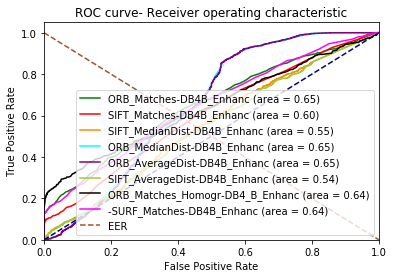

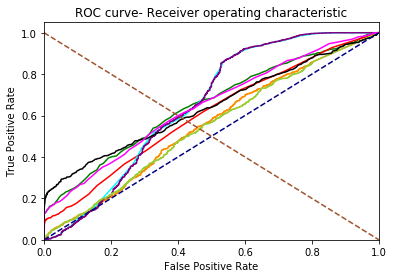

No. of Matches using ORB: EER = 0.3912665562918748
No. of Matches using SIFT: EER = 0.42967291083099907
Median Distances using SIFT: EER = 0.45750000000000046
Median Distances using ORB: EER = 0.4088759636563877
Average Distances using ORB: EER = 0.40501077586207374
Average Distances using SIFT: EER = 0.4630208333333333
No. of Matches with ORB after Homography- Enhanced DB4_B: EER = 0.41510416666666666
No. of Matches using SURF: EER = 0.4005147058823532


In [34]:
fpr1, tpr1, thresholds1 = roc_curve(matching_labels.flatten(), ORb_totalFeatures_DB4_B_normalized.flatten())
fpr2, tpr2, thresholds2 = roc_curve(matching_labels.flatten(), SIFT_totalFeatures_DB4_B_normalized.flatten())
fpr3, tpr3, thresholds3 = roc_curve(distance_labels.flatten(), SIFT_FeatureDistances_DB4_B_normalized.flatten())
fpr4, tpr4, thresholds4 = roc_curve(distance_labels.flatten(), ORB_MedianDistances_DB4_B_normalized.flatten())
fpr5, tpr5, thresholds5 = roc_curve(distance_labels.flatten(), ORB_AverageDistances_DB4_B_normalized.flatten())
fpr6, tpr6, thresholds6 = roc_curve(distance_labels.flatten(), SIFT_AverageDistances_DB4_B_normalized.flatten())
fpr7, tpr7, thresholds7 = roc_curve(matching_labels.flatten(), ORB_matches_Homogr_DB4_B_Enh_normal.flatten())
fpr8, tpr8, thresholds8 = roc_curve(matching_labels.flatten(), SURF_totalMatches_DB4_B_Enhanced_normal.flatten())

roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
roc_auc5 = auc(fpr5, tpr5)
roc_auc6 = auc(fpr6, tpr6)
roc_auc7 = auc(fpr7, tpr7)
roc_auc8 = auc(fpr8, tpr8)


plt.figure()
plt.plot(fpr1, tpr1, color='green', label='ORB_Matches-DB4B_Enhanc (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='red', label='SIFT_Matches-DB4B_Enhanc (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='darkorange', label='SIFT_MedianDist-DB4B_Enhanc (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, color='cyan', label='ORB_MedianDist-DB4B_Enhanc (area = %0.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, color='purple', label='ORB_AverageDist-DB4B_Enhanc (area = %0.2f)' % roc_auc5)
plt.plot(fpr6, tpr6, color='yellowgreen', label='SIFT_AverageDist-DB4B_Enhanc (area = %0.2f)' % roc_auc6)
plt.plot(fpr7, tpr7, color='black', label='ORB_Matches_Homogr-DB4_B_Enhanc (area = %0.2f)' % roc_auc7)
plt.plot(fpr8, tpr8, color='magenta', label='-SURF_Matches-DB4B_Enhanc (area = %0.2f)' % roc_auc8)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.plot([0, 1], [1, 0], color='sienna', linestyle='--', label='EER')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve- Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

plt.figure()
plt.plot(fpr1, tpr1, color='green', label='ORB_Matches-DB4B_Enhanc (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='red', label='SIFT_Matches-DB4B_Enhanc (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='darkorange', label='SIFT_MedianDist-DB4B_Enhanc (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, color='cyan', label='ORB_MedianDist-DB4B_Enhanc (area = %0.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, color='purple', label='ORB_AverageDist-DB4B_Enhanc (area = %0.2f)' % roc_auc5)
plt.plot(fpr6, tpr6, color='yellowgreen', label='SIFT_AverageDist-DB4B_Enhanc (area = %0.2f)' % roc_auc6)
plt.plot(fpr7, tpr7, color='black', label='ORB_Matches_Homogr-DB4_B_Enhanc (area = %0.2f)' % roc_auc7)
plt.plot(fpr8, tpr8, color='magenta', label='-SURF_Matches-DB4B_Enhanc (area = %0.2f)' % roc_auc8)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.plot([0, 1], [1, 0], color='sienna', linestyle='--', label='EER')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve- Receiver operating characteristic')
#plt.legend(loc="lower right")
plt.show()


#Calculate the EER for each case
eer1 = brentq(lambda x : 1. - x - interp1d(fpr1, tpr1)(x), 0., 1.)
eer2 = brentq(lambda x : 1. - x - interp1d(fpr2, tpr2)(x), 0., 1.)
eer3 = brentq(lambda x : 1. - x - interp1d(fpr3, tpr3)(x), 0., 1.)
eer4 = brentq(lambda x : 1. - x - interp1d(fpr4, tpr4)(x), 0., 1.)
eer5 = brentq(lambda x : 1. - x - interp1d(fpr5, tpr5)(x), 0., 1.)
eer6 = brentq(lambda x : 1. - x - interp1d(fpr6, tpr6)(x), 0., 1.)
eer7 = brentq(lambda x : 1. - x - interp1d(fpr7, tpr7)(x), 0., 1.)
eer8 = brentq(lambda x : 1. - x - interp1d(fpr8, tpr8)(x), 0., 1.)
print('No. of Matches using ORB: EER =', eer1)
print('No. of Matches using SIFT: EER =', eer2)
print('Median Distances using SIFT: EER =', eer3)
print('Median Distances using ORB: EER =', eer4)
print('Average Distances using ORB: EER =', eer5)
print('Average Distances using SIFT: EER =', eer6)
print('No. of Matches with ORB after Homography- Enhanced DB4_B: EER =', eer7)
print('No. of Matches using SURF: EER =', eer8)

### Initial database DB4_B without enhancement-normalization

Now, the same process is repeated for the images contained in the database DB4_B, without having been enhanced or normalized. Just in their initial state.

In [35]:
ORB_FeatureSum_DB4_B_Initial = totalFeaturesArray(databaseInitial4, ORBdetector)
SIFT_FeatureSum_DB4_B_Initial = totalFeaturesArray(databaseInitial4, SIFTdetector)
SIFT_MedianDistances_DB4_B_Initial = distancesArray(databaseInitial4, SIFTdetector, 'median_distance')
ORB_MedianDistances_DB4_B_Initial = distancesArray(databaseInitial4, ORBdetector, 'median_distance')
ORB_AverDistances_DB4_B_Initial = distancesArray(databaseInitial4, ORBdetector, 'average_distance')
SIFT_AverDistances_DB4_B_Initial = distancesArray(databaseInitial4, SIFTdetector, 'average_distance')
Matches_ORB_AfterHomography_initialDb4 = ORBwithHomography(databaseInitial4)
SURF_FeatureSum_DB4_B_Initial = totalFeaturesArray(databaseInitial4, SURFdetector)

Rescale values between 0 and 1

In [43]:
ORb_Features_Initial_DB4_B_normalized=normalization(ORB_FeatureSum_DB4_B_Initial)
SIFT_Features_Initial_DB4_B_normalized=normalization(SIFT_FeatureSum_DB4_B_Initial)
SIFT_MedDist_Initial_DB4_B_normalized=normalization(SIFT_MedianDistances_DB4_B_Initial)
ORB_MedDist_Initial_DB4_B_normalized=normalization(ORB_MedianDistances_DB4_B_Initial)
ORB_AverDist_Initial_DB4_B_normalized=normalization(ORB_AverDistances_DB4_B_Initial)
SIFT_AverDist_Initial_DB4_B_normalized=normalization(SIFT_AverDistances_DB4_B_Initial)
ORB_matches_Homogr_DB4_B_Init_normal=normalization(Matches_ORB_AfterHomography_initialDb4)
SURF_Features_Initial_DB4_B_normalized=normalization(SURF_FeatureSum_DB4_B_Initial)

Plot the ROC

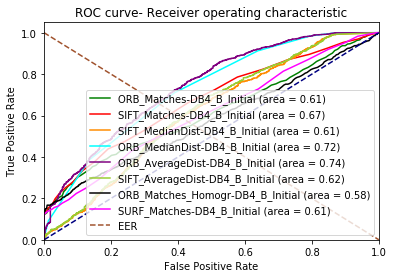

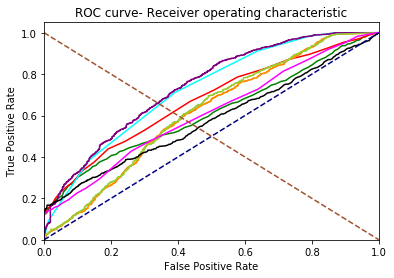

No. of Matches using ORB: EER = 0.44358756188118814
No. of Matches using SIFT: EER = 0.38454268292682925
Median Distances using SIFT: EER = 0.41107047872340424
Median Distances using ORB: EER = 0.345855117820324
Average Distances using ORB: EER = 0.33999999999999814
Average Distances using SIFT: EER = 0.4109374999991403
No. of Matches with ORB after Homography- Initial_DB4_B: EER = 0.4595366379310345
No. of Matches using SURF: EER = 0.43133460541474666


In [45]:
fpr1, tpr1, thresholds1 = roc_curve(matching_labels.flatten(), ORb_Features_Initial_DB4_B_normalized.flatten())
fpr2, tpr2, thresholds2 = roc_curve(matching_labels.flatten(), SIFT_Features_Initial_DB4_B_normalized.flatten())
fpr3, tpr3, thresholds3 = roc_curve(distance_labels.flatten(), SIFT_MedDist_Initial_DB4_B_normalized.flatten())
fpr4, tpr4, thresholds4 = roc_curve(distance_labels.flatten(), ORB_MedDist_Initial_DB4_B_normalized.flatten())
fpr5, tpr5, thresholds5 = roc_curve(distance_labels.flatten(), ORB_AverDist_Initial_DB4_B_normalized.flatten())
fpr6, tpr6, thresholds6 = roc_curve(distance_labels.flatten(), SIFT_AverDist_Initial_DB4_B_normalized.flatten())
fpr7, tpr7, thresholds7 = roc_curve(matching_labels.flatten(), ORB_matches_Homogr_DB4_B_Init_normal.flatten())
fpr8, tpr8, thresholds8 = roc_curve(matching_labels.flatten(), SURF_Features_Initial_DB4_B_normalized.flatten())

roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
roc_auc5 = auc(fpr5, tpr5)
roc_auc6 = auc(fpr6, tpr6)
roc_auc7 = auc(fpr7, tpr7)
roc_auc8 = auc(fpr8, tpr8)

plt.figure()
plt.plot(fpr1, tpr1, color='green', label='ORB_Matches-DB4_B_Initial (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='red', label='SIFT_Matches-DB4_B_Initial (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='darkorange', label='SIFT_MedianDist-DB4_B_Initial (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, color='cyan', label='ORB_MedianDist-DB4_B_Initial (area = %0.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, color='purple', label='ORB_AverageDist-DB4_B_Initial (area = %0.2f)' % roc_auc5)
plt.plot(fpr6, tpr6, color='yellowgreen', label='SIFT_AverageDist-DB4_B_Initial (area = %0.2f)' % roc_auc6)
plt.plot(fpr7, tpr7, color='black', label='ORB_Matches_Homogr-DB4_B_Initial (area = %0.2f)' % roc_auc7)
plt.plot(fpr8, tpr8, color='magenta', label='SURF_Matches-DB4_B_Initial (area = %0.2f)' % roc_auc8)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.plot([0, 1], [1, 0], color='sienna', linestyle='--', label='EER')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve- Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


plt.figure()
plt.plot(fpr1, tpr1, color='green', label='ORB_Matches-DB4_B_Initial (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='red', label='SIFT_Matches-DB4_B_Initial (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='darkorange', label='SIFT_MedianDist-DB4_B_Initial (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, color='cyan', label='ORB_MedianDist-DB4_B_Initial (area = %0.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, color='purple', label='ORB_AverageDist-DB4_B_Initial (area = %0.2f)' % roc_auc5)
plt.plot(fpr6, tpr6, color='yellowgreen', label='SIFT_AverageDist-DB4_B_Initial (area = %0.2f)' % roc_auc6)
plt.plot(fpr7, tpr7, color='black', label='ORB_Matches_Homogr-DB4_B_Initial (area = %0.2f)' % roc_auc7)
plt.plot(fpr8, tpr8, color='magenta', label='SURF_Matches-DB4_B_Initial (area = %0.2f)' % roc_auc8)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.plot([0, 1], [1, 0], color='sienna', linestyle='--', label='EER')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve- Receiver operating characteristic')
plt.show()


#Calculate the EER for each case
eer1 = brentq(lambda x : 1. - x - interp1d(fpr1, tpr1)(x), 0., 1.)
eer2 = brentq(lambda x : 1. - x - interp1d(fpr2, tpr2)(x), 0., 1.)
eer3 = brentq(lambda x : 1. - x - interp1d(fpr3, tpr3)(x), 0., 1.)
eer4 = brentq(lambda x : 1. - x - interp1d(fpr4, tpr4)(x), 0., 1.)
eer5 = brentq(lambda x : 1. - x - interp1d(fpr5, tpr5)(x), 0., 1.)
eer6 = brentq(lambda x : 1. - x - interp1d(fpr6, tpr6)(x), 0., 1.)
eer7 = brentq(lambda x : 1. - x - interp1d(fpr7, tpr7)(x), 0., 1.)
eer8 = brentq(lambda x : 1. - x - interp1d(fpr8, tpr8)(x), 0., 1.)
print('No. of Matches using ORB: EER =', eer1)
print('No. of Matches using SIFT: EER =', eer2)
print('Median Distances using SIFT: EER =', eer3)
print('Median Distances using ORB: EER =', eer4)
print('Average Distances using ORB: EER =', eer5)
print('Average Distances using SIFT: EER =', eer6)
print('No. of Matches with ORB after Homography- Initial_DB4_B: EER =', eer7)
print('No. of Matches using SURF: EER =', eer8)

The results in this database are not that good comparing to previous databases. The perfomance of ORB homography is not the same good as in previous cases. Also, the ORB using average and median distance seems to have the best perfomance in both normalized database and to the one which is not normalized. Finally, in the version where no enhancement has been applied the AUC are bigger in a sense, than in the version where we apply enhancement. 